In [2]:
# https://www.kaggle.com/janiobachmann/s-p-500-time-series-forecasting-with-prophet

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from fbprophet import Prophet

# Statsmodels widely known for forecasting than Prophet
# import statsmodels.api as sm
# from scipy import stats
# from pandas.core import datetools
# from plotly import tools
# import plotly.plotly as py
# import plotly.tools as tls
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs. init_notebook_mode, plot, iplot
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

In [17]:
df = pd.read_csv('all_stocks_5yr.csv')
df

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [18]:
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [20]:
df['Name'].value_counts()

AAL     1259
NRG     1259
NOC     1259
NLSN    1259
NKE     1259
        ... 
DXC      215
BHGE     152
BHF      143
DWDP     109
APTV      44
Name: Name, Length: 505, dtype: int64

In [21]:
df = df.rename(columns={'Name':'Ticks'})

In [22]:
amzn = df.loc[df['Ticks']=='AMZN']
amzn.head()

,date,open,high,low,close,volume,Ticks
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN


In [23]:
amzn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 46387 to 47645
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Ticks   1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 78.7+ KB


In [24]:
# change to datetime format
amzn_df = amzn.copy()
amzn_df.loc[:, 'date'] = pd.to_datetime(amzn.loc[:,'date'], format = '%Y/%m/%d')
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 46387 to 47645
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Ticks   1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 78.7+ KB


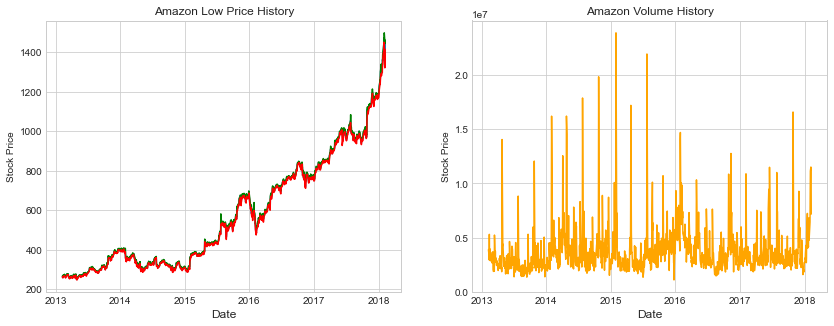

In [25]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(amzn_df['date'], amzn_df['close'])
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Stock Price')
ax1.set_title('Amazon Close Price History')

ax1.plot(amzn_df['date'], amzn_df['high'], color='green')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Stock Price')
ax1.set_title('Amazon High Price History')

ax1.plot(amzn_df['date'], amzn_df['low'], color='red')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Stock Price')
ax1.set_title('Amazon Low Price History')

ax2.plot(amzn_df['date'], amzn_df['volume'], color='orange')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Stock Price')
ax2.set_title('Amazon Volume History')

plt.show()

Steps for using Prophet:

* Make sure you replace closing price for y and date for ds.
* Fit that dataframe to Prophet in order to detect future patterns.
* Predict the upper and lower prices of the closing price.

In [26]:
ph_df = amzn_df[['date','close']]
ph_df.rename(columns={'close':'y', 'date':'ds'}, inplace=True)

ph_df

,ds,y
46387,2013-02-08,261.95
46388,2013-02-11,257.21
46389,2013-02-12,258.70
46390,2013-02-13,269.47
46391,2013-02-14,269.24
...,...,...
47641,2018-02-01,1390.00
47642,2018-02-02,1429.95
47643,2018-02-05,1390.00
47644,2018-02-06,1442.84


In [27]:
m = Prophet()

m.fit(ph_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
# create future dates
future_prices = m.make_future_dataframe(periods=365)
# predict prices
forecast = m.predict(future_prices)
future_prices

,ds
0,2013-02-08
1,2013-02-11
2,2013-02-12
3,2013-02-13
4,2013-02-14
...,...
1619,2019-02-03
1620,2019-02-04
1621,2019-02-05
1622,2019-02-06


In [29]:
forecast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2013-02-08,254.750864,224.398387,284.870275
1,2013-02-11,253.137453,220.094077,283.154601
2,2013-02-12,252.846818,220.716015,284.704722
3,2013-02-13,252.569844,220.794825,284.799159
4,2013-02-14,252.142465,219.804306,284.544941
...,...,...,...,...
1619,2019-02-03,1809.659414,1116.236461,2432.576602
1620,2019-02-04,1785.516925,1086.205081,2405.901628
1621,2019-02-05,1785.807015,1087.568876,2411.029259
1622,2019-02-06,1785.945449,1079.471018,2424.091627


Text(0.5, 1.0, 'daily Prediction')

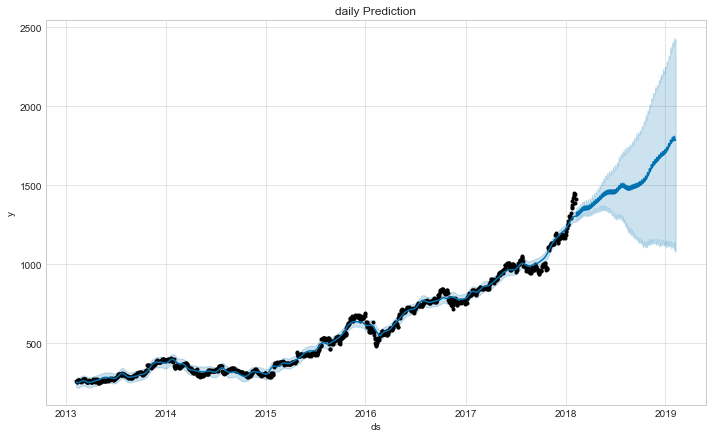

In [30]:
# import matplotlib.dates as mdates

# starting_date = dt.datetime(2018,4,7)
# starting_date1 = mdates.date2num(starting_date)
# trend_date = dt.datetime(2018,6,7)
# trend_date1 = mdates.date2num(trend_date)

# pointing_arrow = dt.datetime(2018,2,18)
# pointing_arrow1 = mdates.date2num(pointing_arrow)

fig = m.plot(forecast)
plt.title('daily Prediction')
# ax1 = fig.add_subplot(111)
# ax1.set_title('Amazon Stock Price Forecast', fontsize=16)
# ax1.set_xlabel('Date', fontsize=12)
# ax1.set_ylabel('Close Price', fontsize=12)

# ax1.annotate('Forecast \n Initialization', xy=(pointing_arrow1, 1350), xytext=(starting_date1, 1700), arrowprops=dict(facecolor='#ff7f50', shrink=0.1),)

# ax1.annotate('Upward Trend', xy=(trend_date1, 1225), xytext=(trend_date1, 950), arrowprops=dict(facecolor='#6cff6c',shrink=0.1),)
# ax1.axhline(y=1260, color='b', linestyle='-')
# plt.show()

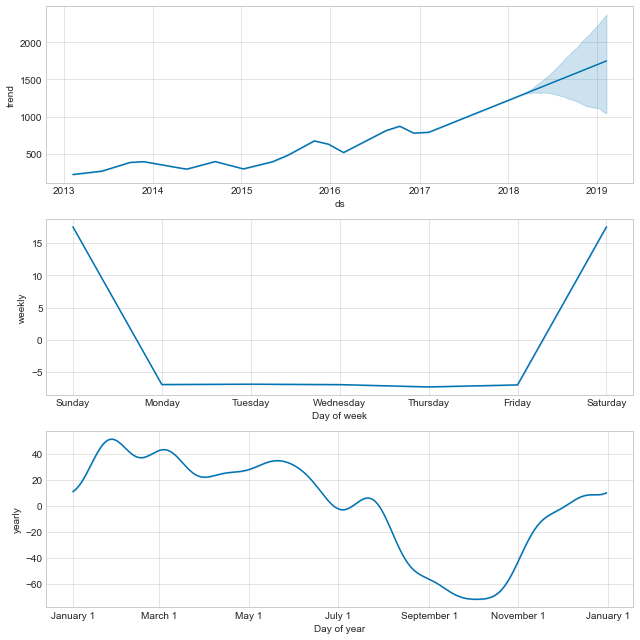

In [31]:
fig2 = m.plot_components(forecast)
plt.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


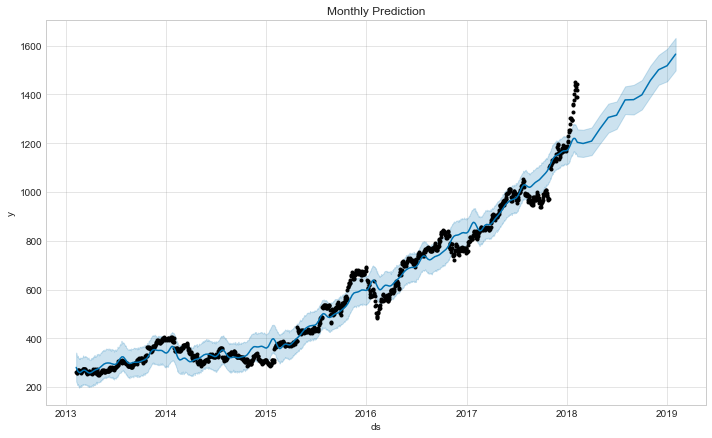

In [32]:
# Monthly predictions
m = Prophet(changepoint_prior_scale=0.01).fit(ph_df)
future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)
plt.title('Monthly Prediction')
plt.show()

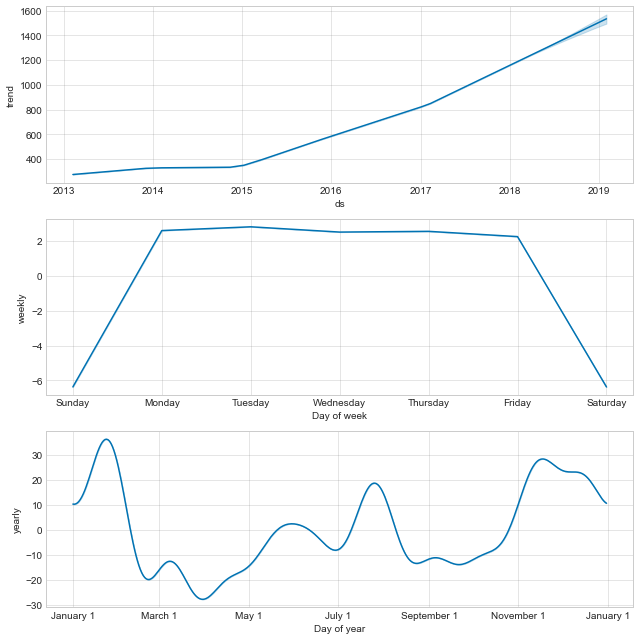

In [33]:
fig = m.plot_components(fcst)
plt.show()

## Stocks more Susceptible to Seasonality Trends:
In this section I want to show some types of stocks that are more vulnerable to seasonality such as airlines, hotel chains or cruiseships. In this example I will use American Airlines to demonstrate how a certain extent of the stock is influenced by seasonality movements.

## Summary:
* December and January tends to be the months were there are more upward trends for the stock.
* July as well but not as much as December and January.
* September tends to be the month with the most downward pressure.

In [34]:
# American Airlines 
aal_df = df.loc[df['Ticks']=='AAL']
aal_df.loc[:,'date'] = pd.to_datetime(aal_df.loc[:,'date'], format = '%Y/%m/%d')
aal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Ticks   1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 78.7+ KB


In [35]:
aal_df

,date,open,high,low,close,volume,Ticks
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
1254,2018-02-01,54.00,54.64,53.59,53.88,3623078,AAL
1255,2018-02-02,53.49,53.99,52.03,52.10,5109361,AAL
1256,2018-02-05,51.99,52.39,49.75,49.76,6878284,AAL
1257,2018-02-06,49.32,51.50,48.79,51.18,6782480,AAL


In [38]:
m = Prophet()

ph_df = aal_df[['date','close']]
ph_df.rename(columns={'date':'ds', 'close':'y'}, inplace=True)

ph_df

,ds,y
0,2013-02-08,14.75
1,2013-02-11,14.46
2,2013-02-12,14.27
3,2013-02-13,14.66
4,2013-02-14,13.99
...,...,...
1254,2018-02-01,53.88
1255,2018-02-02,52.10
1256,2018-02-05,49.76
1257,2018-02-06,51.18


In [39]:
m.fit(ph_df)
future_prices = m.make_future_dataframe(periods=365)

forecast = m.predict(future_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
forecast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2013-02-08,13.014607,9.800792,16.342398
1,2013-02-11,13.172950,9.620041,16.363755
2,2013-02-12,13.264907,10.129684,16.732983
3,2013-02-13,13.402268,9.980188,16.971468
4,2013-02-14,13.471475,9.796112,16.907094
...,...,...,...,...
1619,2019-02-03,63.785396,55.545203,72.744170
1620,2019-02-04,61.954920,53.628575,70.574495
1621,2019-02-05,61.947360,53.925721,70.546530
1622,2019-02-06,61.988639,53.508732,70.906271


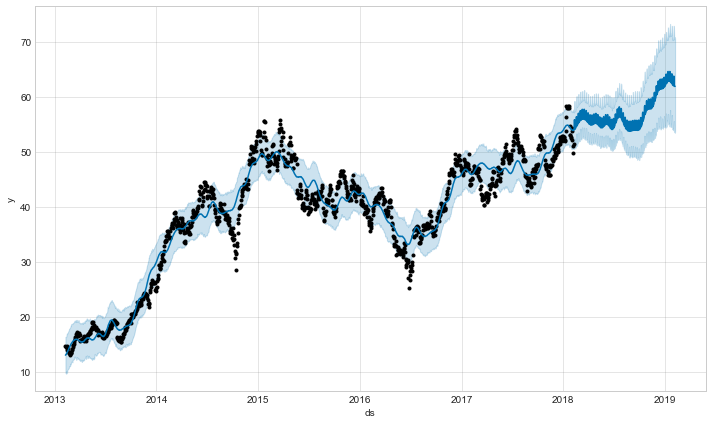

In [41]:
figure = m.plot(forecast)

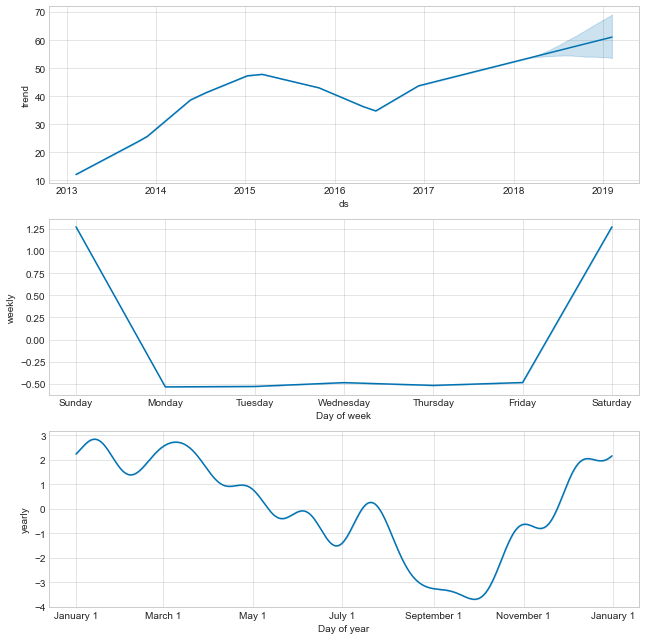

In [42]:
fig2 = m.plot_components(forecast)
plt.show()